# Imports
As we're luckily standing on the shoulders of giants, we can do some imports.

In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [66]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from collections import defaultdict
import numpy as np
import imageio
import scipy.io as sio
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import scipy.stats

# Load Data
Let's load and convert the data, so we can use it later.

In [256]:
DATASETS = ['cifar10', 'mnist', 'cub', 'awa2',
            'imagenetfeatures', 'apyfeatures', 'zero_shot_cub']
# dataset = 'awa2'
# dataset = 'cub'
dataset = 'zero_shot_cub'

data_path = '/home/swezel/projects/urdtc/data/'
figure_path = data_path + '../thesis/images/'


# attribute name lookup (first attr_id is 0) 
with open (data_path + 'cub/attributes.txt', 'r') as f:
    attributes=f.readlines()
attribute_name_dict = {str(int(attr.split(' ')[0])-1): attr.split(' ')[1] for attr in attributes}

def get_dataset_config(dataset, cnn_type, max_iters):
    input_channels = None
    if dataset == 'mnist':
        input_channels = 1
        if cnn_type == 'cnn':
            cnn_output_size = 4*4*100
        elif cnn_type == 'resnet':
            cnn_output_size = 512
        elif cnn_type == 'shallowcnn':
            cnn_output_size = 4*4*64
        out_freq = 100
        #assert max_iters > 4
    elif dataset == 'cifar10':
        input_channels = 3
        if cnn_type == 'cnn':
            cnn_output_size = 8*8*32
        elif cnn_type == 'resnet' or cnn_type == 'resnet18':
            cnn_output_size = 512
        elif cnn_type == 'shallowcnn':
            cnn_output_size = 4*4*64
        out_freq = 100
        #assert max_iters > 4
    elif dataset == 'cub':
        input_channels = 3
        if cnn_type == 'cnn':
            # cnn_output_size = 32*32*32
            cnn_output_size = 280900 # the above does not work? Maybe because of dataloader issue?
        elif cnn_type == 'resnet' or cnn_type == 'resnet152':
            cnn_output_size = 2048
        out_freq = 10
    elif dataset == 'zero_shot_cub':
        input_channels = 3
        if cnn_type == 'cnn':
            # cnn_output_size = 32*32*32
            cnn_output_size = 280900 # the above does not work? Maybe because of dataloader issue?
        elif cnn_type == 'resnet' or cnn_type == 'resnet152':
            cnn_output_size = 2048
        out_freq = 10
        #assert max_iters > 8
    elif dataset == 'awa2':
        input_channels = 3
        if cnn_type == 'cnn':
#             cnn_output_size = 32*32*32  # TODO: check
            cnn_output_size = 2048
        elif cnn_type == 'resnet' or cnn_type == 'resnet152':
            cnn_output_size = 2048
        out_freq = 10
        #assert max_iters > 6
    elif dataset == 'imagenetfeatures':
        cnn_output_size = 2048
        out_freq = 100
        #assert max_iters > 10
    elif dataset == 'apyfeatures':
        cnn_output_size = 2048
        out_freq = 10
        #assert max_iters > 5

    return input_channels, cnn_output_size, out_freq

class DataLoader(object):
    def __init__(self, dataset='mnist'):
        assert dataset in DATASETS
        self.dataset = dataset

    def load_data(self, batch_size=100, num_workers=4, root='./data/'):

        if self.dataset == 'mnist':
            #transform_train = transforms.ToTensor()
            #transform_test = transforms.ToTensor()
            class AddGaussianNoise(object):
                def __init__(self, mean=0., std=1.):
                    self.std = std
                    self.mean = mean

                def __call__(self, tensor):
                    output = tensor + torch.randn(tensor.size()) * self.std + self.mean
                    return output.clamp(0., 1.)

                def __repr__(self):
                    return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

            transform_train = transforms.Compose([
               transforms.ToTensor(),
               #AddGaussianNoise(0., 0.2)
               #transforms.Normalize((0.1307,), (0.3081,))
            ])
            transform_test = transforms.Compose([
               transforms.ToTensor(),
               #AddGaussianNoise(0., 0.2)
               #transforms.Normalize((0.1307,), (0.3081,))
            ])
            classes = [i for i in range(10)]
            dataset_class = dsets.MNIST

        elif self.dataset == 'cifar10':
            transform_train = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])
            transform_test = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])
            classes = ('plane', 'car', 'bird', 'cat',
                       'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
            dataset_class = dsets.CIFAR10

        elif self.dataset == 'cub':

            transform_train = transforms.Compose([transforms.ToPILImage(),
                                                  transforms.RandomResizedCrop(224),
                                                  transforms.RandomHorizontalFlip(),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                                                       std=(0.229, 0.224, 0.225))])

            transform_test = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.Resize(224),
                                                 transforms.CenterCrop(224),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                                                      std=(0.229, 0.224, 0.225))])

            dataset_class = CUB
            classes = list(range(200))

        elif self.dataset == 'zero_shot_cub':

            transform_train = transforms.Compose([transforms.ToPILImage(),
                                                  transforms.RandomResizedCrop(224),
                                                  transforms.RandomHorizontalFlip(),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                                                       std=(0.229, 0.224, 0.225))])

            transform_test = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.Resize(224),
                                                 transforms.CenterCrop(224),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                                                      std=(0.229, 0.224, 0.225))])

            dataset_class = ZeroShotCUB
            classes = list(range(200))            
            
            

        elif self.dataset == 'awa2':
            transform_train = transforms.Compose([transforms.ToPILImage(),
                                                  transforms.RandomResizedCrop(224),
                                                  transforms.RandomHorizontalFlip(),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                                                       std=(0.229, 0.224, 0.225))])

            transform_test = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.Resize(224),
                                                 transforms.CenterCrop(224),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                                                      std=(0.229, 0.224, 0.225))])

            dataset_class = AWA2
            classes = list(range(50))

        elif self.dataset == 'apyfeatures':
            transform_train = transforms.ToTensor()
            transform_test = transforms.ToTensor()

            dataset_class = APYFeatures
            classes = list(range(32))

        elif self.dataset == 'imagenetfeatures':
            transform_train = transforms.ToTensor()
            transform_test = transforms.ToTensor()

            dataset_class = ImageNetFeatures
            classes = list(range(1000))

        train_dataset = dataset_class(root=root,
                                      train=True,
                                      transform=transform_train,
                                      download=True)

        test_dataset = dataset_class(root=root,
                                     train=False,
                                     transform=transform_test)

        val_size = int(len(train_dataset) * 0.1)
        train_size = len(train_dataset) - val_size

        train_dataset, val_dataset = torch.utils.data.dataset.random_split(train_dataset, [train_size, val_size])

        train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers)

        val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                                 batch_size=batch_size,
                                                 shuffle=False,
                                                 num_workers=num_workers)

        test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  num_workers=num_workers)

        dataloaders = {'train': train_loader,
                       'val': val_loader,
                       'test': test_loader}

        return dataloaders, classes

class CUB(Dataset):
    """CUB200-2011 dataset."""
    attribute_file = 'attributes/class_attribute_labels_continuous.txt'

    def __init__(self, root, train=True, transform=None, normalize=True,
                 download=None):
        self.root = os.path.join(root, 'cub')
        self.train = train
        self.transform = transform
        self.data_dir = os.path.join(self.root, 'images')

        train_test_split = pd.read_csv(os.path.join(self.root, 'train_test_split.txt'),
                                       sep=' ', index_col=0, header=None)
        if train:
            is_train_image = 1
        else:
            is_train_image = 0
        self.img_ids = train_test_split[train_test_split[1] == is_train_image].index.tolist()
        self.id_to_img = pd.read_csv(os.path.join(self.root, 'images.txt'),
                                     sep=' ', index_col=0, header=None)

        raw_mtx = np.loadtxt(os.path.join(self.root,
                                          self.attribute_file))
        raw_mtx[raw_mtx == -1] = 0
        raw_mtx = raw_mtx / raw_mtx.max()
        self.attribute_mtx = torch.tensor(raw_mtx, dtype=torch.float)

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_name = self.id_to_img[self.id_to_img.index == img_id].values[0][0]
        img_path = os.path.join(self.data_dir, img_name)

        img = imageio.imread(img_path, pilmode='RGB')
        label = int(img_name[:3]) - 1

        if self.transform:
            img = self.transform(img)

        return img, label, img_path

    
class ZeroShotCUB(Dataset):
    """CUB200-2011 dataset."""
    attribute_file = 'attributes/class_attribute_labels_continuous.txt'

    def __init__(self, root, train=True, transform=None, normalize=True,
                 download=None):
        self.root = os.path.join(root, 'cub')
        self.train = train
        self.transform = transform
        self.data_dir = os.path.join(self.root, 'images')

        train_test_split = pd.read_csv(os.path.join(self.root, 'zero_attr_train_test_split.txt'),
                                       sep=' ', index_col=0, header=None)
        if train:
            is_train_image = 1
        else:
            is_train_image = 0
        self.img_ids = train_test_split[train_test_split[1] == is_train_image].index.tolist()
        self.id_to_img = pd.read_csv(os.path.join(self.root, 'images.txt'),
                                     sep=' ', index_col=0, header=None)

        raw_mtx = np.loadtxt(os.path.join(self.root,
                                          self.attribute_file))
        raw_mtx[raw_mtx == -1] = 0
        raw_mtx = raw_mtx / raw_mtx.max()
        self.attribute_mtx = torch.tensor(raw_mtx, dtype=torch.float)

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_name = self.id_to_img[self.id_to_img.index == img_id].values[0][0]
        img_path = os.path.join(self.data_dir, img_name)

        img = imageio.imread(img_path, pilmode='RGB')
        label = int(img_name[:3]) - 1

        if self.transform:
            img = self.transform(img)

        return img, label, img_path
    
    
class AWA2(Dataset):
    """Animals with Attributes 2 dataset."""
    split_file = 'train_test_classification_split.txt'
    data_dir = 'awa2'
    attribute_file = 'predicate-matrix-continuous.txt'

    def __init__(self, root, train=True, transform=None, normalize=True,
                 download=None):
        self.root = os.path.join(root, self.data_dir)
        self.train = train
        self.transform = transform

        meta_data = pd.read_csv(os.path.join(self.root,
                                             self.split_file),
                                sep=' ', index_col=0, header=None)
        if train:
            is_train_image = 1
        else:
            is_train_image = 0
        self.img_ids = meta_data[meta_data[3] == is_train_image].index.tolist()
        self.id_to_img = meta_data

        raw_mtx = np.loadtxt(os.path.join(self.root,
                                          self.attribute_file))
        raw_mtx[raw_mtx == -1] = 0
        raw_mtx = raw_mtx / raw_mtx.max()
        self.attribute_mtx = torch.tensor(raw_mtx, dtype=torch.float)

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_meta_data = self.id_to_img[self.id_to_img.index == img_id]
        img_name = img_meta_data.values[0][0]
        img_path = os.path.join(self.root, img_name)

        img = imageio.imread(img_path, pilmode='RGB')
        label = img_meta_data.values[0][1] - 1

        if self.transform:
            img = self.transform(img)

        return img, label

In [257]:
device = torch.device('cuda')
# device = torch.device('cpu')

# create dataloader objects for train, val and test
dl = DataLoader(dataset=dataset)
# dataloaders, classes = dl.load_data(4, 4, data_path)# 128 insted of 
dataloaders, classes = dl.load_data(64, 4, data_path)# 128 insted of 

# attributes (312 column vectors with 200 rows) -> each class can be described with 312 attributes
# percentage of time, human annotator thought, the attribute was present
attribute_mtx = dataloaders['train'].dataset.dataset.attribute_mtx

# create binary encoding for class attributes
attribute_mtx[attribute_mtx < 0.5] = 0.0
attribute_mtx[attribute_mtx >= 0.5] = 1.0
attribute_mtx = attribute_mtx.to(device) # cuda
attribute_size = attribute_mtx.size(1) # number of available attributes

In [383]:
# print(attribute_mtx[0])

c = 0


for class_id in range(attribute_mtx.size(0)):
#     for attr_id in range(attribute_mtx.size(1)):
#         print('...')
#     attr_values = [attribute_mtx[class_id][x].item() for x in range(6)]
#     if attr_values == [0.0 for x in range(6)]:
        
    if (attribute_mtx[class_id][308].item()==0) or (attribute_mtx[class_id][236].item()==0) or (attribute_mtx[class_id][235].item()==0.)or (attribute_mtx[class_id][145].item()==0.)or (attribute_mtx[class_id][151].item()==0.):

#         print(class_id)
        c+=1
    else:
        print(class_id)
#     print(attr_values)
#     if (attribute_mtx[class_id][3].item()==0) & (attribute_mtx[class_id][1].item()==0.) & (attribute_mtx[class_id][1].item()==0.):
#         c += 1
print()
print(c)
# print(attribute_mtx[82][40])

#1
#308
# 101
# 235
# 145
# 151

11
18
19
25
26
41
74
75
98
113
138
139
161
180
182
183
199

183


In [245]:
# for i in range(312):
#     print(i)
#     print(attribute_mtx[:,i].sum(dim=0).item())
#     print()
# # print(attribute_mtx.sum(dim=0))

0
0.0

1
15.0

2
0.0

3
4.0

4
15.0

5
2.0

6
77.0

7
45.0

8
4.0

9
8.0

10
46.0

11
0.0

12
0.0

13
0.0

14
46.0

15
12.0

16
1.0

17
1.0

18
0.0

19
0.0

20
84.0

21
39.0

22
2.0

23
21.0

24
9.0

25
47.0

26
0.0

27
0.0

28
0.0

29
48.0

30
17.0

31
2.0

32
1.0

33
0.0

34
0.0

35
76.0

36
34.0

37
3.0

38
25.0

39
3.0

40
12.0

41
0.0

42
0.0

43
0.0

44
15.0

45
30.0

46
0.0

47
0.0

48
0.0

49
1.0

50
31.0

51
91.0

52
8.0

53
22.0

54
131.0

55
6.0

56
11.0

57
12.0

58
9.0

59
39.0

60
0.0

61
0.0

62
0.0

63
43.0

64
12.0

65
2.0

66
2.0

67
0.0

68
0.0

69
58.0

70
21.0

71
3.0

72
21.0

73
1.0

74
0.0

75
48.0

76
0.0

77
2.0

78
0.0

79
7.0

80
31.0

81
0.0

82
0.0

83
0.0

84
28.0

85
6.0

86
1.0

87
1.0

88
0.0

89
0.0

90
58.0

91
23.0

92
3.0

93
13.0

94
0.0

95
0.0

96
2.0

97
1.0

98
0.0

99
8.0

100
2.0

101
41.0

102
4.0

103
0.0

104
10.0

105
4.0

106
12.0

107
0.0

108
0.0

109
0.0

110
15.0

111
26.0

112
1.0

113
0.0

114
0.0

115
1.0

116
36.0

117
74.0

118

# Define Models
Here, we continue by defining the various models that our uRDTC consists of.

In [258]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

class CNN(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.net = nn.Sequential(nn.Conv2d(in_channels, 20, kernel_size=3, stride=1),
                                 nn.ReLU(True),
                                 nn.BatchNorm2d(20),
                                 nn.Conv2d(20, 50, kernel_size=5, stride=2),
                                 nn.ReLU(True),
                                 nn.BatchNorm2d(50),
                                 nn.Conv2d(50, 100, kernel_size=5, stride=2),
                                 nn.ReLU(True))

    def forward(self, x):
        return self.net(x)

class DropoutCNN(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 20, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(50, 100, kernel_size=5, stride=2)
    
    def forward(self, x):
        x = F.dropout2d(F.relu(self.conv1(x)), 0.2)
        x = F.dropout2d(F.relu(self.conv2(x)), 0.2)
        x = F.dropout2d(F.relu(self.conv3(x)), 0.2)
        
        return x

def get_cnn(in_channels, type='cnn', pretrained_cnn_weights=None,
            freeze_weights=False, default_pretrained=False):
    TYPES = ['cnn', 'dropoutcnn', 'resnet152'] # TYPES = ['cnn', 'shallowcnn', 'resnet', 'resnet152']
    assert type in TYPES

    if type == 'cnn':
        cnn = CNN(in_channels)
    if type == 'dropoutcnn':
        cnn = DropoutCNN(in_channels)
#     if type == 'resnet152':
#         cnn = models.resnet152(pretrained=default_pretrained)
    else:
        cnn = Identity()

    # if pretrained_cnn_weights:
    #     if type == 'resnet152':
    #         cnn.fc = nn.Linear(cnn.fc.in_features, pretrained_cnn_weights['fc.weight'].size(0))
    #     cnn.load_state_dict(pretrained_cnn_weights)
    if pretrained_cnn_weights:
        cnn.load_state_dict(pretrained_cnn_weights)
    
    return cnn

In [259]:
class OC(nn.Module):
    def __init__(self, model_type, num_classes, cnn_type, input_channels, cnn_out_size,
                 dataset, decision_size=2, max_iters=20, attribute_size=20, attribute_mtx=None, attribute_coef=0.5, hidden_size=100,
                 tau_initial=5, tau_target=0.5, use_pretrained=False, shallow=False, strategy='aRDTC'):
        super(OC, self).__init__()
        assert model_type in ['xoc'] #, 'ioc']
        self.model_type = model_type
        self.num_classes = num_classes
        self.attribute_size = attribute_size
        self.attribute_mtx = attribute_mtx
        self.attribute_coef = attribute_coef if attribute_mtx is not None else 0.
        self.decision_size = decision_size # change keyword default to 3?
        self.tau_initial = tau_initial
        self.tau_target = tau_target
        self.max_iters = max_iters
        self.shallow = shallow
        self.stats = defaultdict(list)
        self.reduced_vocab_size = 2
        self.strategy = strategy

        self.no_lstm = False

        #self.init_attribute_matrix(attribute_mtx, attribute_size, attribute_coef, use_bin_attr)

        self.cnn = self.init_cnn(cnn_type, input_channels, dataset, use_pretrained)
        self.init_network(hidden_size, decision_size, num_classes, attribute_size, cnn_out_size, shallow)

        self.init_losses()



        self.phase = 'train'

        # for stats
        self.logits_list = []
        self.sigmas_list = []
#         self.labels_list
        self.binary_features_list = []
        self.labels_list = []
        self.used_attributes_list = []
        self.certain_attrs = []
        self.attribute_accuracies = []
        self.drop_ratios = []
        self.mean_sigmas = []
        

    def init_network(self, hidden_size, decision_size, num_classes, attribute_size, cnn_out_size, shallow):
        assert decision_size > 1

        # LSTM initialization parameters
        if self.no_lstm:
            self.init_h0 = nn.Parameter(torch.zeros(attribute_size * decision_size), requires_grad=False)
            self.init_c0 = nn.Parameter(torch.zeros(attribute_size * decision_size), requires_grad=False)
        else:
            self.init_h0 = nn.Parameter(torch.zeros(hidden_size).uniform_(-0.01, 0.01), requires_grad=True)
            self.init_c0 = nn.Parameter(torch.zeros(hidden_size).uniform_(-0.01, 0.01), requires_grad=True)

        if self.no_lstm:
            self.lstm = lambda x, y: (None, (x.squeeze(), x.squeeze()))
        else:
            self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True)

        if self.no_lstm:
            classifier_in = attribute_size * decision_size
        else:
            classifier_in = attribute_size * decision_size

        self.classifier = nn.Sequential(#nn.BatchNorm1d(classifier_in) if not self.no_lstm else Identity(),
                                        nn.Linear(classifier_in, hidden_size),
                                        nn.ReLU(inplace=True),
                                        nn.BatchNorm1d(hidden_size),
                                        nn.Linear(hidden_size, num_classes))

        if self.model_type == 'xoc':
            if self.no_lstm:
                feat_select_in_size = attribute_size * decision_size
            else:
                feat_select_in_size = hidden_size
            feat_select_out_size = attribute_size
            pre_lstm_size = attribute_size * decision_size * 2

            bin_feat_type = 'shallow' if shallow else 'dropoutmlp' #'mlp'
            feat_select_type = 'mlp_small'

        elif self.model_type == 'ioc':
            bin_feat_type = 'identity'
            feat_select_type = 'mlp_big'

            if not shallow:
                feat_select_in_size = cnn_out_size + hidden_size
                feat_select_out_size = decision_size
                pre_lstm_size = feat_select_out_size
            else:
                feat_select_in_size = hidden_size
                feat_select_out_size = cnn_out_size * decision_size
                pre_lstm_size = decision_size

        if feat_select_type == 'mlp_small':
            self.feature_selection = nn.Sequential(nn.BatchNorm1d(feat_select_in_size) if not self.no_lstm else Identity(),
                                                   nn.Linear(feat_select_in_size , hidden_size),
                                                   nn.ReLU(inplace=True),
                                                   nn.BatchNorm1d(hidden_size),
                                                   nn.Linear(hidden_size, feat_select_out_size))
        elif feat_select_type == 'mlp_big':
            self.feature_selection = nn.Sequential(nn.BatchNorm1d(feat_select_in_size) if not self.no_lstm else Identity(),
                                                   nn.Linear(feat_select_in_size, hidden_size),
                                                   nn.ReLU(inplace=True),
                                                   nn.BatchNorm1d(hidden_size),
                                                   nn.Linear(hidden_size, hidden_size),
                                                   nn.ReLU(inplace=True),
                                                   nn.BatchNorm1d(hidden_size),
                                                   nn.Linear(hidden_size, feat_select_out_size))

        if bin_feat_type == 'identity':
            self.binary_features = Identity()
        elif bin_feat_type == 'shallow':
            class AddZeros(nn.Module):
                def __init__(self):
                    super().__init__()

                def forward(self, x):
                    zeros = torch.zeros_like(x).unsqueeze(2)
                    return torch.cat((x.unsqueeze(2), zeros), dim=2)

            self.binary_features = AddZeros()
        elif bin_feat_type == 'mlp':
            self.binary_features = nn.Sequential(nn.BatchNorm1d(cnn_out_size), # use dropout
                                                 nn.Linear(cnn_out_size, hidden_size),
                                                 nn.ReLU(inplace=True),
                                                 nn.BatchNorm1d(hidden_size), # use dropout
                                                 nn.Linear(hidden_size, hidden_size),
                                                 nn.ReLU(inplace=True),
                                                 nn.BatchNorm1d(hidden_size), # use dropout
                                                 nn.Linear(hidden_size, attribute_size * self.reduced_vocab_size))
        elif bin_feat_type == 'dropoutmlp':
            self.binary_features = nn.Sequential(
                                                nn.Linear(cnn_out_size, hidden_size),
                                                nn.ReLU(inplace=False),
                                                nn.Dropout(0.2, inplace=False),
                                                nn.Linear(hidden_size, hidden_size),
                                                nn.ReLU(inplace=False),
                                                nn.Dropout(0.2, inplace=False),
                                                nn.Linear(hidden_size, attribute_size * self.reduced_vocab_size)
                                                )

        if self.no_lstm:
            self.pre_lstm = Identity()
        else:
            self.pre_lstm = nn.Sequential(#nn.BatchNorm1d(pre_lstm_size),
                                          nn.Linear(pre_lstm_size, hidden_size),
                                          nn.ReLU(inplace=True),
                                          nn.BatchNorm1d(hidden_size))


        # Temperature parameters
        self.binary_features.tau = nn.Parameter(torch.tensor([self.tau_initial], dtype=torch.float), requires_grad=True)
        self.feature_selection.tau = nn.Parameter(torch.tensor([self.tau_initial], dtype=torch.float), requires_grad=True)
        #self.init_weights()
    



    def get_attribute_uncertainty_batch(self, image_features, n=100, batch_size=64):
        
        with torch.no_grad():

            outputs = torch.zeros((n, batch_size, attribute_size * self.reduced_vocab_size), device=device) # init outputs with dummy values

    #         if self.phase=='test':
    #         print(self.binary_features.training)

            if not self.binary_features.training:
                current_phase = 'test'
                self.binary_features.train()

            else:
                current_phase = 'train'
    #         print(self.binary_features.training)
    #         print()

    #             for layer in self.binary_features:
    #                 if isinstance(layer, torch.nn.modules.dropout._DropoutNd):
    #                     layer.train()

            for i in range(n):
                outputs[i] = F.softmax(self.binary_features(image_features))

            if current_phase=='test':
    #         if self.phase=='test':
                self.binary_features.eval()
    #             for layer in self.binary_features:
    #                 if isinstance(layer, torch.nn.modules.dropout._DropoutNd):
    #                     layer.eval()
    #                 else:
    #                     layer.train()

            sigmas = outputs.std(dim=0)

            return sigmas
    
    
    def get_attribute_uncertainty(self, image_features, n=10, batch_size=64):
        outputs = torch.zeros((n, batch_size, attribute_size * self.reduced_vocab_size), device=device)
        
        if self.phase == 'train':
            for i in range(n):
                outputs[i] = F.softmax(self.binary_features(image_features))
#                 outputs[i] = self.binary_features(image_features)

        if self.phase == 'test':
            for layer in self.binary_features:
                if isinstance(layer, torch.nn.modules.dropout._DropoutNd):
                    layer.train()
#             self.binary_features.train()
            for i in range(n):
                outputs[i] = F.softmax(self.binary_features(image_features))
#                 outputs[i] = self.binary_features(image_features)

            for layer in self.binary_features:
                if isinstance(layer, torch.nn.modules.dropout._DropoutNd):
                    layer.eval()
#             self.binary_features.eval()
        
        sigmas = outputs.var(dim=0)
        sigmas += (0.01**2 * 0.5)/(2 * image_features.size(0) * weight_decay)
#         print(sigmas.mean())

        return sigmas
  
    def init_attribute_matrix(self, attribute_mtx, attribute_size, attribute_coef, use_bin_attr):
        if attribute_coef > 0.:
            if use_bin_attr:
                attribute_mtx[attribute_mtx < 0.5] = 0.
                attribute_mtx[attribute_mtx >= 0.5] = 1.
            self.attribute_mtx = nn.Parameter(attribute_mtx, requires_grad=False)
            self.attribute_size = attribute_mtx.size(1)
        else:
            self.attribute_mtx = None
            self.attribute_size = attribute_size

    def toggle_update_schedule(self):
        # TODO: see a few lines below
        #self.update_binary_features = not self.update_binary_features
        pass

    def get_param_groups(self):
        cnn_params = []
        tree_params = []
        for n, p in self.named_parameters():
            if p.requires_grad:
                # TODO: introduce parameter that allows to switch between training alternatingly
                # Currently commented out, so both groups contain the same parameters
                """
                if n.startswith('cnn') or n.startswith('binary_features'):
                    print('CNN', n)
                    cnn_params.append(p)
                else:
                    print('OTHER', n)
                    tree_params.append(p)
                """
                cnn_params.append(p)
                tree_params.append(p)
        return tree_params, cnn_params

    def set_optimizer(self, optimizers):
        self.tree_optimizer = optimizers[0]
        self.cnn_optimizer = optimizers[1]

    def set_scheduler(self, schedulers):
        self.tree_scheduler = schedulers[0]
        self.cnn_scheduler = schedulers[1]

    def get_optimizer(self):
        if self.update_binary_features:
            return self.cnn_optimizer
        else:
            return self.tree_optimizer

    def get_scheduler(self):
        if self.update_binary_features:
            return self.cnn_scheduler
        else:
            return self.tree_scheduler

    def init_losses(self):
        self.cls_loss = nn.CrossEntropyLoss()
        self.attr_loss = nn.BCEWithLogitsLoss()
        self.update_binary_features = False

    def init_cnn(self, cnn_type, input_channels, dataset, use_pretrained):
        if cnn_type == 'None':
            cnn = Identity()
        else:
            if use_pretrained:
                # TODO add data_path and change state dict name 
                # cnn_state_dict = torch.load('pretrained/{}_{}.pth'.format(dataset, cnn_type))
#                 cnn_state_dict = torch.load('pretrained/cub_resnet152.pkl')# .format(dataset, cnn_type)
                cnn_state_dict = torch.load('pretrained/{}_resnet152.pkl'.format(dataset))# .format(dataset, cnn_type)

                cnn = get_cnn(input_channels, cnn_type, cnn_state_dict, freeze_weights=True)
            else:
                cnn = get_cnn(input_channels, cnn_type)

        return cnn

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.fill_(0.1)

    def set_tau(self, epoch):
        annealing_factor = epoch / 100
        self.tau = self.tau_initial
        self.tau -= (self.tau_initial - self.tau_target) * annealing_factor
        self.tau = max(self.tau, self.tau_target)

    def process_images(self, images):
        batch_size = images.size(0)
        img_feats = self.cnn(images)
        img_feats = img_feats.view(img_feats.size(0), -1)
        image_features = self.binary_features(img_feats)
        # print(image_features.size())
        ################## remove attrs code
#         sigmas = self.get_attribute_uncertainty_batch(img_feats,n=100, batch_size=batch_size)
        
        if self.strategy == 'remRDTC':
            with torch.no_grad():
                sigmas = self.get_attribute_uncertainty(img_feats, n=5, batch_size=images.size(0))
            uncertain_attrs = (sigmas > 0.005).float() # get binary uncertain attrs
            certain_attrs = 1. - uncertain_attrs
            mask = certain_attrs.detach()
            inv_mask = 1-mask
            min_value = image_features.min()
            image_features = image_features * mask # put zeros where uncertain attts are
            image_features = image_features - (inv_mask.detach()*min_value.detach()) #*-500

#         sigmas.detach()
#         sigmas.cuda()
#         self.mean_sigmas.append(sigmas.mean().item())
#         drop_ratio = (sigmas>0.005).float().sum()/(images.size(0)*attribute_size*2.)
#         min_value = image_features.min()
#         min_value.detach()
#         self.drop_ratios.append(drop_ratio)





        #############################################################
#         if not self.training:

#             self.sigmas_list.append(sigmas)
            # self.logits_list.append(image_features)
            # image_features = torch.cat((attribute_logits, sigmas),1)
        
        
        ################## remove attrs
#         uncertain_attrs = (sigmas > 0.005).float() # get binary uncertain attrs
#         certain_attrs = 1. - uncertain_attrs
#         mask = certain_attrs.detach()#(torch.FloatTensor(image_features.size()).uniform_() > 0.050).float().to(device)
        if self.strategy == 'randRDTC':
            mask = (torch.FloatTensor(image_features.size()).uniform_() > 0.050).float().to(device)
            inv_mask = 1-mask
#         self.drop_ratios.append((inv_mask.sum()/39936.0).item())
#         mask.detach()
            min_value = image_features.min()
            image_features = image_features * mask # put zeros where uncertain attts are
            image_features = image_features - (inv_mask.detach()*min_value.detach()) #*-500
        ##############################################################

        if self.model_type == 'xoc':
            attribute_logits = image_features.view(-1, 2)


            attributes_softmax = F.softmax(attribute_logits / self.binary_features.tau, dim=1)
            attributes_hard = self.argmax(attributes_softmax, dim=1)
            image_features = attributes_hard.view(images.size(0), -1, 2)

            # TODO: generalize to different decision sizes
            bin_attribute_logits = attribute_logits - attribute_logits[:, 1].unsqueeze(-1)
            self.attribute_logits = bin_attribute_logits[:, 0].view(images.size(0), -1)

            self.collect_hist_stats('AttributesSoft', F.softmax(attribute_logits, dim=1))
            self.collect_hist_stats('AttributesSoftTemp', attributes_softmax)
            self.collect_hist_stats('AttributesHard', attributes_hard.max(dim=1)[1])

        return image_features

    def make_decision(self, lstm_out, binary_features, iter, sigma=[], max_uncertainty=0.2):
        if self.model_type == 'xoc':
            # Perform categorical feature selection
            selection_logits = self.feature_selection(lstm_out)
            # print(selection_logits[0][:10])
            if self.training:
                hard_selection = F.gumbel_softmax(selection_logits, tau=self.feature_selection.tau, hard=True)
            else:
               
                # sigma = self.get_attribute_uncertainty(binary_features)
                # sigma = sigma[:,:312]#.squeeze() 
                # certain_logits = torch.where(sigma>max_uncertainty,
                #                              selection_logits,
                #                              torch.zeros_like(selection_logits).new_full(selection_logits.size(), -10000)) # -10000
                hard_selection = self.argmax(selection_logits, dim=1)
                # print(hard_selection.size())
                # print(binary_features.size())
                # print(hard_selection.unsqueeze(2).size())


            # Get single decision
            self.saved_attribute_selection = hard_selection.max(dim=1)[1]
            

            decision = (hard_selection.unsqueeze(2) * binary_features).view(-1, self.attribute_size * self.decision_size)
            # print(decision[0])
        elif self.model_type == 'ioc':
            if not self.shallow:
                features = torch.cat((lstm_out, binary_features), dim=1)
                selection_logits = self.feature_selection(features)
            else:
                shallow_weights = self.feature_selection(lstm_out)
                shallow_weights = shallow_weights.view(lstm_out.size(0), -1, self.decision_size)
                selection_logits = torch.bmm(binary_features.unsqueeze(1), shallow_weights)
                selection_logits = selection_logits.squeeze()

            soft_decision = F.softmax(selection_logits / self.tau_selection, dim=1)
            hard_selection = self.argmax(soft_decision, dim=1)
            decision = hard_selection

        # Collect statistics
        self.collect_hist_stats('SelectionSoft', F.softmax(selection_logits, dim=1).max(dim=1)[0], iter)
        self.collect_hist_stats('SelectionSoftTemp', F.softmax(selection_logits / self.feature_selection.tau, dim=1).max(dim=1)[0], iter)
        self.collect_hist_stats('SelectionHard', hard_selection.max(dim=1)[1], iter)

        return decision

    def get_initial_state(self, batch_size):
        h0 = self.init_h0.view(1, 1, -1).expand(-1, batch_size, -1)
        c0 = self.init_c0.view(1, 1, -1).expand(-1, batch_size, -1)
        state = (h0.contiguous(), c0.contiguous())
        return state

    def argmax(self, y_soft, dim):
        index = y_soft.max(dim, keepdim=True)[1]
        y_hard = torch.zeros_like(y_soft).scatter_(dim, index, 1.0)
        argmax = y_hard - y_soft.detach() + y_soft
        return argmax

    def collect_hist_stats(self, name, data, i=None):
        # TODO: investigate performance impact of collecting these statistics,
        # make option to disable and/or autodisable if tree is too large
        if 'Hard' in name:
            stat_str = 'Hist/' + name
            data = data.detach().cpu()
            self.stats[stat_str].append(data)
            if i is not None:
                stat_str += str(i)
                self.stats[stat_str].append(data)

    def get_hist_stats(self, reset=True):
        stats = self.stats
        if reset:
            self.stats = defaultdict(list)
        #return None
        return stats

    def reset_stats(self):
        self.unique_attributes = [set() for i in range(self.max_iters)]
        if self.attribute_coef > 0.:
            self.attr_pred_correct = [0 for i in range(self.max_iters)]

    def update_unique_attributes(self, unique_attributes, iter):
        for attr in unique_attributes:
            self.unique_attributes[iter].add(attr.item())

    def get_unique_attributes(self):
        uniq_per_iter = []
        for i in range(self.max_iters):
            iter_set = self.unique_attributes[i]
            for j in range(i+1):
                if j == i:
                    continue
                iter_set = iter_set.union(self.unique_attributes[j])
            uniq_per_iter.append(len(iter_set))
        return uniq_per_iter

    def update_attr_preds(self, attr_correct, iter):
        self.attr_pred_correct[iter] += attr_correct

    def get_attr_acc(self, total_cnt):
        correct_cumsum = np.cumsum(self.attr_pred_correct)
        cnt_per_iter = (np.arange(self.max_iters) + 1) * total_cnt
        return correct_cumsum / cnt_per_iter

    def init_tree_stats(self):
        # TODO: investigate performance impact of collecting these statistics,
        # make option to disable and/or autodisable if tree is too large

        # Would be nice if this worked with sparse tensors
        n_possible_states = self.decision_size ** self.max_iters
        self.label_stats = torch.zeros((n_possible_states * self.decision_size,
                                        self.num_classes), dtype=torch.int32)
                                       #layout=torch.sparse_coo)
        self.selection_stats = torch.zeros((n_possible_states,
                                            self.attribute_size),
                                           dtype=torch.int32)
                                           #layout=torch.sparse_coo)

    def update_tree_stats(self, attribute_selection, attribute_decisions, labels, iter):
        # TODO: investigate performance impact of collecting these statistics,
        # make option to disable and/or autodisable if tree is too large

        if iter == 0:
            self.batch_states = torch.zeros_like(labels)
            for i in range(labels.size(0)):
                self.label_stats[self.batch_states[i], labels[i]] += 1

        for i in range(labels.size(0)):
            self.selection_stats[self.batch_states[i], attribute_selection[i]] += 1
            self.batch_states[i] += (attribute_decisions[i] + 1) * self.decision_size ** iter
            self.label_stats[self.batch_states[i], labels[i]] += 1

    def run_iteration(self, binary_features, state, decision_hist, iter, sigma=[]): # also pass sigma here
        lstm_out = state[0].squeeze(0)

        # Make binary decision
        decision = self.make_decision(lstm_out, binary_features, iter, sigma)

        if decision_hist is None:
            decision_hist = decision
        else:
            decision_hist = (decision_hist + decision).clamp(0., 1.)

        scaled_dh = decision_hist / decision_hist.sum(dim=1).unsqueeze(1).detach()
        if self.no_lstm:
            lstm_in = scaled_dh
        else:
            lstm_in = torch.cat((scaled_dh, decision), dim=1)

        # Update LSTM state
        lstm_in = self.pre_lstm(lstm_in).unsqueeze(1)
        _, state = self.lstm(lstm_in, state)

        # Get current classification
        classifier_in = scaled_dh
        #classifier_in = state[1].squeeze(0)
        #classifier_in = torch.cat((decision_hist, self.lstm_state_bn(lstm_state)), dim=1)
        classification = self.classifier(classifier_in)

        return classification, state, decision_hist

    def tree_rollout(self, images, labels, keep_tree_stats=False):
        # Set initial state
        state = self.get_initial_state(images.size(0))

        # Get categorical features once
        binary_features = self.process_images(images)
        # collect attribute stats
        # self.binary_features_list.append(binary_features)
        # self.labels_list.append(labels)

#         attr_acc = (binary_features[:,:,0] == attribute_mtx[labels]).sum().long() / 19968.0 #/ (312*labels.size(0))
        attr_acc = (binary_features[:,:,0] == attribute_mtx[labels]).sum().long() / float((attribute_size*labels.size(0)))    
#         print(attr_acc)
        self.attribute_accuracies.append(attr_acc.item())

        ######################### extended vocab code 
        if self.strategy == 'extRDTC':
            with torch.no_grad():
                img_feats = self.cnn(images)
                img_feats = img_feats.view(img_feats.size(0), -1)
    #             image_features = self.binary_features(img_feats) # maybe do those with no grad as well
                sigmas = self.get_attribute_uncertainty(img_feats, n=5, batch_size=images.size(0))
            if not self.training:
                self.sigmas_list.append(sigmas)
                self.labels_list.append(labels)
    #         sigmas.detach()
        
#         ########### remove attrs code
#         uncertain_attrs = (sigmas > 0.005).float()
#         certain_attrs = 1. - uncertain_attrs
#         uncertain_attrs = uncertain_attrs.view(images.size(0), attribute_size, 2)
#         certain_attrs = certain_attrs.view(images.size(0), attribute_size, 2)
# #         print(certain_attrs[0])
#         mask = torch.bernoulli(torch.empty(binary_features.size(), device=device).uniform_(1, 1))
        
#         binary_features = binary_features * mask#certain_attrs.detach() # clean binary_features from uncertain attrs (replace with 0)
        
        

#         ######################################### remove attrs code end
        
# #         self.mean_sigmas.append(sigmas.mean().item())
            sigmas = (sigmas > 0.005).float() # 0.004
            sigmas_new = torch.zeros(images.size(0), attribute_size,1, device=device)
            sigmas_new += sigmas.view(images.size(0),attribute_size,2)[:,:,0].unsqueeze(2)
            sigmas_new += sigmas.view(images.size(0),attribute_size,2)[:,:,1].unsqueeze(2)
            sigmas_new = (sigmas_new > 0.0).float() # <- denotes uncertain attributes

            self.drop_ratios.append((sigmas_new.sum()/19968.0).item())

            # obtain uncertainty and append to decision
            new_attribute_decisions = torch.cat([binary_features, torch.zeros_like(sigmas_new, device=device)], dim=2)
            certain_decisions = 1. - sigmas_new
            uncertain_onehot = torch.tensor([[0., 0., 1.]], device=device).repeat(images.size(0), attribute_size, 1)
            uncertain_attrs_removed = certain_decisions.detach() * new_attribute_decisions
            shaped_uncertain_attrs = sigmas_new.detach() * uncertain_onehot
            final_attribute_decisions = uncertain_attrs_removed + shaped_uncertain_attrs
#             binary_features = final_attribute_decisions
#         ######################### extended vocab code end
        
        

        loss = 0
        j = 0
        # stats
        all_classifications = []
        all_chosen_attr = []
        all_attribute_preds = []

        decision_hist = None
        while j < self.max_iters:
            classification, state, decision_hist = self.run_iteration(binary_features, state, decision_hist, j+1)
            loss += (1. - self.attribute_coef) * self.cls_loss(classification, labels)
            all_classifications.append(classification)

            self.update_unique_attributes(self.saved_attribute_selection.unique(), j)

            if self.model_type == 'xoc' and self.attribute_coef > 0.:
                chosen_attribtutes = self.saved_attribute_selection
                attribute_logits = self.attribute_logits

                attribute_target = self.attribute_mtx[labels, :].gather(1, chosen_attribtutes.unsqueeze(1)).squeeze()
                attribute_pred = attribute_logits.gather(1, chosen_attribtutes.unsqueeze(1)).squeeze()
                loss += self.attribute_coef * self.attr_loss(attribute_pred,
                                                             attribute_target)
                


                attribute_pred_bin = (attribute_pred > 0.).long()
                self.update_attr_preds((attribute_pred_bin == attribute_target).sum().item(), j)

                
            if keep_tree_stats:
                attribute_pred = self.attribute_logits.gather(1, self.saved_attribute_selection.unsqueeze(1)).squeeze()
                self.update_tree_stats(self.saved_attribute_selection, (attribute_pred > 0.).long(),labels, j)

                # all_chosen_attr.append(self.saved_attribute_selection)
                all_attribute_preds.append((attribute_pred > 0.).long())

            j += 1
        
            all_chosen_attr.append(self.saved_attribute_selection)

        self.tmp_saved_chosen_attr = torch.stack(all_chosen_attr, dim=1)

        if keep_tree_stats:
            self.tmp_saved_cls = torch.stack(all_classifications, dim=1)
            # self.tmp_saved_chosen_attr = torch.stack(all_chosen_attr, dim=1)
            self.tmp_saved_attr_pred = torch.stack(all_attribute_preds, dim=1)
        # else:
        #     self.tmp_saved_chosen_attr = None

        loss = loss / self.max_iters


        ####################################
        # if binary_features.size(0)==64:
            # self.used_attributes_list.append(self.tmp_saved_chosen_attr)
            # self.certain_attrs.append(certain_decisions)
            # chosen_attributes_binary = torch.tensor([1 if x in [int(attr) for attr in self.tmp_saved_chosen_attr[:,x]] else 0 for x in range(312)], device=device)
            # self.used_attributes_list.append(chosen_attributes_binary)
            # self.sigmas_list.append(sigmas_all)
        ####################################
        return all_classifications, loss, self.tmp_saved_chosen_attr

    def forward(self, images, labels, keep_tree_stats=False):
        classification, loss, chosen_attribtutes = self.tree_rollout(images, labels, keep_tree_stats)
        # classification, loss, chosen_attributes = self.tree_rollout(images, labels, keep_tree_stats)

        return classification, loss#, chosen_attributes

# Training
After defining our models, we can continue by training it. For this, we first set some hyperparameters and then continue by defining a trainer class.

In [260]:
# fake input arguments
model_type = 'xoc'
cnn_type = 'uncertain'
# cnn_type = 'resnet'
attribute_coef = 0.2
# attribute_size = 85#312 #1024
# attribute_size = 312 #1024
learning_rate = 0.001
weight_decay = 0.00001
step_size = 50
num_epochs = 2
max_iters = 10
hidden_size = 1000
cnn_out_size = 2048

In [261]:

class Trainer:
    def __init__(self, model, dataloaders, num_epochs, device, log_freq, log_path): # todo remove stats dict

        self.model = model
        self.dataloaders = dataloaders
        self.num_epochs = num_epochs
        self.device = device
        self.log_freq = log_freq
        self.log_path = log_path
        
        self.logger = SummaryWriter(self.log_path)

        #### TODO remove this workaround and use tensorboard
#         with open('/content/drive/My Drive/rdtc/data/' + 'logs/' + 'stats_dict.json') as json_file:
#             self.stats_dict = json.load(json_file)
        
        self.classifications_dict = {'correct':{'num':0, 'uncertainty':0},
                                     'incorrect':{'num':0, 'uncertainty':0}}

        self.uncertainty_stats = {'epoch_{}'.format(epoch):{'used_attributes':[],'sigmas':[], 'num_attrs_discarded':0} for epoch in range(num_epochs+2)}
        self.mean_attr_accs = []
        self.mean_drop_ratio = []
        self.mean_sigmas = []
        ############

    def train(self):
        self.model.phase = 'train'
        self.train_model(self.dataloaders['train'])

    def test(self):
        self.model.phase = 'test'
        self.test_model(self.dataloaders['test'], 'test', None, hard=False) # was: hard=True
        self.model.phase = 'train'
        return self.model.label_stats, self.model.selection_stats

    def topk_correct(self, output, target, topk=(1,)):
        maxk = max(topk)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        target_masks = []
        target_cnt = []
        for i in range(self.model.num_classes):
            target_masks.append((target == i).unsqueeze(0))
            target_cnt.append(target_masks[i].sum().item())

        res = []
        for k in topk:
            correct_k = [(correct[:k] * tm).view(-1).float().sum(0, keepdim=True).item() for tm in target_masks]
            res.append(np.array(correct_k))
        return res, np.array(target_cnt)

    def log_stats(self, phase, epoch, epoch_stats, hist_stats,
                  unique_attr_stats, attr_acc):
        for k in range(len(epoch_stats[0])):
        # for k in range(1):

            self.logger.add_scalar('Top1Accuracy{}/{}'.format(k+1, phase), epoch_stats[0][k], epoch)
            # self.logger.add_scalar('Top5Accuracy{}/{}'.format(k+1, phase), epoch_stats[1][k], epoch)
            # self.logger.add_scalar('Top1MeanClassAccuracy{}/{}'.format(k+1, phase), epoch_stats[3][k], epoch)
            # self.logger.add_scalar('Top5MeanClassAccuracy{}/{}'.format(k+1, phase), epoch_stats[4][k], epoch)
            # if unique_attr_stats is not None:
            #     self.logger.add_scalar('UniqueAttributes{}/{}'.format(k+1, phase), unique_attr_stats[k], epoch)
            # if attr_acc is not None:
            #     self.logger.add_scalar('AttributeAccuracy{}/{}'.format(k+1, phase), attr_acc[k], epoch)
        self.logger.add_scalar('Loss/'+phase, epoch_stats[2], epoch)

        if hist_stats is not None:
            for name, data in hist_stats.items():
                data = torch.cat(data, dim=0).flatten()
                if name.startswith('SelectionHard'):
                    bins = self.model.attribute_size
                elif name.startswith('AttributesHard'):
                    bins = self.model.decision_size
                else:
                    bins = 'tensorflow'
                self.logger.add_histogram(name, data, epoch, bins=bins)

    def test_model(self, data_loader, phase, epoch, hard=False):
        # Test the Model
        self.model.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
        n_stats = self.model.max_iters if hasattr(self.model, 'max_iters') else 1
        correct_1 = np.zeros((n_stats, self.model.num_classes))
        correct_5 = np.zeros((n_stats, self.model.num_classes))
        total = 0
        total_cnt = np.zeros((1, self.model.num_classes))
        total_loss = 0

        if isinstance(self.model, OC):
            self.model.reset_stats()
            if hard:
                self.model.init_tree_stats()

        with torch.no_grad():
            for idx, data in enumerate(data_loader):
                if len(data) == 2:
                    images, labels = data
                    attributes = None
                else:
                    images, labels, attributes = data
                    #attributes = attributes.to(self.device)
                images = images.to(self.device)
                labels = labels.to(self.device)
                
                classification, loss = self.model(images, labels, hard)
                #####################################
#                 print(labels.size())
#                 print(labels[0].item())
                #####################################

                # Collect stats
                total_loss += loss.item()
                total += labels.size(0)
                for k in range(len(classification)):
                    ######################
                    # print(classification[k].data)
                    # print(labels[k])
                    # print()
                    # print(classification[k].data.size())
                    # print(labels.size())
                    # print()
                    # values, indices = torch.max(classification[k], -1)
                    # for i in range(classification[k].size(0)):

                        # print(indices[i].item(),labels[i].item())
                        # if indices[i].item()==labels[i].item():
                        #     self.classifications_dict['correct']+=1
                        # if indices[i].item()!=labels[i].item():
                        #     self.classifications_dict['incorrect']+=1              
          
                    ######################
                    ctopk, target_cnt = self.topk_correct(classification[k].data, labels, (1, 5))
                    c1, c5 = ctopk
                    # print(target_cnt)
                    correct_1[k] += c1
                    correct_5[k] += c5
                total_cnt[0] += target_cnt

                
                # if classification[-1].size(0)==64:
                #     values, indices = torch.max(classification[-1], -1)
                #     image_features_ = self.model.cnn(images)
                #     image_features_ = image_features_.view(image_features_.size(0), -1)
                #     # self.model.binary_features = self.model.binary_features.train()
                #     sigmas = self.model.get_attribute_uncertainty_batch(image_features_, batch_size=64)
                #     sigmas.cuda()
                #     # self.model.binary_features = self.model.binary_features.eval()
                #     _, _, attributes_used = self.model.tree_rollout(images, labels, True)
                #     for i in range(classification[-1].size(0)): # iterate over batch
                #         chosen_attributes_binary = torch.tensor([1 if x in [int(attr) for attr in attributes_used[i]] else 0 for x in range(624)], device=device)
                #         self.model.used_attributes_list.append(chosen_attributes_binary)
                #         # chosen_attributes_binary.cuda()
                #         used_sigmas = sigmas[i] * chosen_attributes_binary
                #         if indices[i].item()==labels[i].item():
                #             self.classifications_dict['correct']['num'] += 1
                #             self.classifications_dict['correct']['uncertainty'] += used_sigmas.sum().item()
                #         if indices[i].item()!=labels[i].item():
                #             self.classifications_dict['incorrect']['num'] += 1
                #             self.classifications_dict['incorrect']['uncertainty'] += used_sigmas.sum().item()
                
        # collect uncertainty stats#############################
        # num_batches = len(model.used_attributes_list)

        # attribute_zeros = torch.zeros(num_batches,624)
        # # attrs_discarded_zeros = torch.zeros(num_batches, 624)
        # sigma_zeros = torch.zeros(1, 624, device=device)
        # num_attrs_discarded = 0
        # for i in range(num_batches):
        #     for batch_index in range(64):
        #         example_attrs = [int(attr) for attr in model.used_attributes_list[i][batch_index]] # 
        #         attribute_zeros[i] += torch.tensor([1 if x in example_attrs else 0 for x in range(624)]) # used attrs binary
        #         used_attrs_binary = torch.tensor([1 if x in example_attrs else 0 for x in range(624)]) # for that example
        #         certain_attrs = model.certain_attrs[i][batch_index]
        #         used_certain_attrs = used_attrs_binary.detach().cpu()[:312] * certain_attrs.detach().cpu()
        #         num_attrs_discarded += torch.abs(used_attrs_binary.sum() - used_certain_attrs.sum())
        #     sigma_zeros += model.sigmas_list[i].mean(dim=0) # add average of batch
        #     # num_attrs_discarded += model.num_attrs_discarded_list[i]

        
        # self.uncertainty_stats['epoch_{}'.format(epoch)]['used_attributes']= attribute_zeros.sum(dim=0)
        # self.model.used_attributes_list = []
        # self.uncertainty_stats['epoch_{}'.format(epoch)]['sigmas'] = sigma_zeros/num_batches
        # self.model.sigmas_list = []
        # self.uncertainty_stats['epoch_{}'.format(epoch)]['num_attrs_discarded'] += num_attrs_discarded
        # model.certain_attrs = []
        # #####################################################################################

        stats = [correct_1.sum(axis=1) / total, correct_5.sum(axis=1) / total, total_loss / total, (correct_1 / total_cnt).mean(axis=1), (correct_5 / total_cnt).mean(axis=1)]
        print('Accuracy ({}), Top1: {:.2%}, Top5: {:.2%}'.format(phase, stats[0][-1], stats[1][-1]))
        self.model.train()  # Change model to 'train' mode

        unique_attr_stats = None
        attr_acc = None
        if epoch is not None:
            if isinstance(self.model, OC):
                hist_stats = self.model.get_hist_stats()
                unique_attr_stats = self.model.get_unique_attributes()
                if self.model.attribute_coef > 0.:
                    attr_acc = self.model.get_attr_acc(total)
                else:
                    attr_acc = None
            else:
                hist_stats = None
            self.log_stats(phase, epoch, stats, hist_stats, unique_attr_stats, attr_acc)

        return stats[0][-1], stats, unique_attr_stats, attr_acc

    def train_model(self, data_laoder):
        max_accuracy = 0
        max_agg_accuracy = 0
        max_ma_accuracy = 0
        max_ma_agg_accuracy = 0

        if isinstance(self.model, OC):
            self.model.reset_stats()

        # Train the Model
        ############### remove this workaround
#         configuration = self.log_path.split('logs/')[1].split('/')[0]
        # self.stats_dict[configuration]['losses'] = []
        ###############################################
        
        for epoch in range(self.num_epochs):
            #self.model.set_tau(epoch)
            optimizer = self.model.get_optimizer()
            n_stats = self.model.max_iters if hasattr(self.model, 'max_iters') else 1
            correct_1 = np.zeros((n_stats, self.model.num_classes))
            correct_5 = np.zeros((n_stats, self.model.num_classes))
            total = 0
            total_cnt = np.zeros((1, self.model.num_classes))
            total_loss = 0

            for i, data in enumerate(data_laoder):
                
                if len(data) == 2:
                    images, labels = data
                    attributes = None
                else:
                    images, labels, attributes = data
                    #attributes = attributes.to(self.device)
                images = images.to(self.device)
                labels = labels.to(self.device)
                optimizer.zero_grad()
                classification, loss = self.model(images, labels)
                

                if loss.grad_fn is not None:
                
                    loss.backward()
                    optimizer.step()

                # Collect stats
                total_loss += loss.item()
                total += labels.size(0)
                for k in range(len(classification)):
                    ctopk, target_cnt = self.topk_correct(classification[k].data, labels, (1, 5))
                    c1, c5 = ctopk
                    correct_1[k] += c1
                    correct_5[k] += c5
                total_cnt[0] += target_cnt

                if (i+1) % self.log_freq == 0:
                    print('Epoch [{}/{}], Iter [{}/{}] Loss: {:.4f}'
                            .format(epoch+1, self.num_epochs, i+1, len(data_laoder)//images.size(0),
                                    loss.item()))
                    ##### TODO remove workaround and use tensurboard
                    # self.stats_dict[configuration]['losses'].append(loss.item())
            
        # with open(data_path + '/logs/' + 'stats_dict.json', 'w') as json_file:
        #     json.dump(self.stats_dict, json_file)
        #     print('stats dict saved...')
                    #############################################

            self.model.get_scheduler().step()
            # if isinstance(self.model, NeuralDecisionForest) or isinstance(self.model, OC):
            #     self.model.toggle_update_schedule()

            stats = [correct_1.sum(axis=1) / total, correct_5.sum(axis=1) / total, total_loss / total, (correct_1 / total_cnt).mean(axis=1), (correct_5 / total_cnt).mean(axis=1)]

            if isinstance(self.model, OC):
                hist_stats = self.model.get_hist_stats()
                unique_attr_stats = self.model.get_unique_attributes()
                if self.model.attribute_coef > 0.:
                    attr_acc = self.model.get_attr_acc(total)
                else:
                    attr_acc = None
            else:
                hist_stats = None
                unique_attr_stats = None
                attr_acc = None
            self.log_stats('train', epoch, stats, hist_stats, unique_attr_stats, attr_acc)
            print('Accuracy (train), Top1: {:.2%}, Top5: {:.2%}'.format(stats[0][-1], stats[1][-1]))
            self.model.phase = 'test'
            val_accuracy, val_stats, _, _ = self.test_model(self.dataloaders['val'],
                                                            'val', epoch+1)
            val_agg_accuracy = val_stats[0].sum()
            val_ma_accuracy = val_stats[3][-1]
            val_ma_agg_accuracy = val_stats[3].sum()

            # reset model stats
            model.sigmas_list = []
            model.labels_list = []
            model.used_attributes_list = []
            model.attribute_accuracies = []
            model.drop_ratios = []
#             self.model.phase = 'test'
            _, test_stats, unique_attr_stats, attr_acc = self.test_model(self.dataloaders['test'], 'test', epoch+1)
            
#             if model.drop_ratios[0].size(0) == 64:
            self.mean_drop_ratio.append(sum(model.drop_ratios)/(len(model.drop_ratios)+1))
            mean_attribute_accuracy = sum(model.attribute_accuracies)/len(model.attribute_accuracies)
            self.mean_sigmas.append(sum(model.mean_sigmas)/(len(model.mean_sigmas)+1))
            self.mean_attr_accs.append(mean_attribute_accuracy)
#             print(mean_attribute_accuracy)
#             print()
            # # collect uncertainty stats
            # self.uncertainty_stats['epoch_{}'.format(epoch)]['used_attributes']=self.model.used_attributes_list
            # self.model.used_attributes_list = []
            # self.uncertainty_stats['epoch_{}'.format(epoch)]['sigmas']=self.model.sigmas_list
            # self.model.sigmas_list = []           
            
            
            
            self.model.phase = 'train'
            if val_accuracy > max_accuracy:
                max_accuracy = val_accuracy
#                 self.save_model('best', test_stats, 0, unique_attr_stats, attr_acc, epoch)
            if val_ma_accuracy > max_ma_accuracy:
                max_ma_accuracy = val_ma_accuracy
#                 self.save_model('best_ma', test_stats, 3, unique_attr_stats, attr_acc, epoch)
            if val_agg_accuracy > max_agg_accuracy and isinstance(self.model, OC):
                max_agg_accuracy = val_agg_accuracy
                self.save_model('best_agg', test_stats, 0, unique_attr_stats, attr_acc, epoch)
            if val_ma_agg_accuracy > max_ma_agg_accuracy and isinstance(self.model, OC):
                max_ma_agg_accuracy = val_ma_agg_accuracy
#                 self.save_model('best_ma_agg', test_stats, 3, unique_attr_stats, attr_acc, epoch)

            self.save_model('latest', test_stats, 0, unique_attr_stats, attr_acc, epoch)
        # with open(data_path + '/logs/' + 'stats_dict.json', 'w') as json_file:
        #     json.dump(self.stats_dict, json_file)
        #     print('stats dict saved...')


    def write_stats_file(self, stats_list, name, epoch, is_float=True):
        fstr = '{:.2f}' if is_float else '{}'
        with open(os.path.join(self.log_path, '{}.txt'.format(name)), 'a') as f:
            acc_str = [fstr.format(100*c1 if is_float else c1) for c1 in stats_list]
            f.write('{} '.format(epoch) + ' '.join(acc_str))
            f.write('\n')

    def save_model(self, name, test_stats, stats_idx, unique_attr_stats, attr_acc, epoch):
        torch.save(self.model.state_dict(),
                   os.path.join(self.log_path, '{}.pth'.format(name)))
        
        # save state dict for vision model separately
        torch.save(self.model.cnn.state_dict(), os.path.join(self.log_path, '{}_vision_model.pth'.format(name)))
        
        
        
        self.write_stats_file(test_stats[stats_idx], name, epoch)

        # if isinstance(self.model, NeuralDecisionForest):
        #     _, test_stats_hard, _, _ = self.test_model(self.dataloaders['test'],
        #                                                'test', epoch+1, hard=True)
        #     self.write_stats_file(test_stats_hard[stats_idx], name+'_hard', epoch)

        if unique_attr_stats is not None:
            self.write_stats_file(unique_attr_stats, name+'_uniqattr', epoch,
                                  is_float=False)

        if attr_acc is not None:
            self.write_stats_file(attr_acc, name+'_attracc', epoch)

        if name != 'latest':
            print('Saved {} model'.format(name))


Let's instance our models...

In [262]:
# get the configuraion parameters of our dataset
in_channels, cnn_out_size, log_freq = get_dataset_config(dataset, 'cnn', 40 )
cnn_out_size = 2048

# initiate the observer classifier model
model = OC('xoc', len(classes), 'dropoutcnn', in_channels,
            cnn_out_size, dataset, 2, 40, # 13 worked
            attribute_size, attribute_mtx, attribute_coef,
            hidden_size, tau_initial=5,
            use_pretrained=False, shallow=False)

# load pretrained resnet backbone
model.cnn = models.resnet152(pretrained=False)
model.cnn.fc = nn.Linear(model.cnn.fc.in_features, torch.load('/home/swezel/projects/urdtc/pretrained/cub_resnet152.pkl')['fc.weight'].size(0))
model.cnn.load_state_dict(torch.load('/home/swezel/projects/urdtc/pretrained/cub_resnet152.pkl'))
# model.cnn.fc = nn.Linear(model.cnn.fc.in_features, torch.load('/home/swezel/projects/urdtc/pretrained/{}_resnet152.pkl'.format(dataset))['fc.weight'].size(0))
# model.cnn.load_state_dict(torch.load('/home/swezel/projects/urdtc/pretrained/{}_resnet152.pkl'.format(dataset)))


model.cnn.fc = nn.Identity()

# set attribute head
model.binary_features = nn.Sequential(nn.BatchNorm1d(cnn_out_size),
                                        nn.Linear(cnn_out_size, hidden_size),
                                        nn.ReLU(inplace=True),
                                        nn.BatchNorm1d(hidden_size),
                                        nn.Dropout(0.5, inplace=False), # dropout after batchnorm
                                        nn.Linear(hidden_size, hidden_size),
                                        nn.ReLU(inplace=True),
                                        nn.BatchNorm1d(hidden_size),
                                        nn.Dropout(0.5, inplace=False),
                                        nn.Linear(hidden_size, attribute_size * 2))

model.binary_features.tau = nn.Parameter(torch.tensor([5], dtype=torch.float), requires_grad=True)
model.to(device);

# freeze resnet backbone for faster training but make all other weights trainable
for param in model.lstm.parameters():
    param.requires_grad=True
for param in model.classifier.parameters():
    param.requires_grad=True
for param in model.feature_selection.parameters():
    param.requires_grad=True
for param in model.binary_features.parameters():
    param.requires_grad=True
for param in model.pre_lstm.parameters():
    param.requires_grad=True
    
for param in model.cnn.parameters():
    param.requires_grad = False
for param in model.cnn.fc.parameters():
    param.requires_grad=True
    
# initiate optimizers
tree_params, cnn_params = model.get_param_groups()
tree_optimizer = torch.optim.Adam(tree_params, lr = learning_rate, weight_decay=weight_decay)
cnn_optimizer = torch.optim.Adam(cnn_params, lr = learning_rate, weight_decay=weight_decay)
optimizer = [tree_optimizer, cnn_optimizer]
# and schedulers
tree_scheduler = torch.optim.lr_scheduler.StepLR(tree_optimizer, step_size=step_size, gamma=0.1)
cnn_scheduler = torch.optim.lr_scheduler.StepLR(cnn_optimizer, step_size=step_size, gamma=0.1)
scheduler = [tree_scheduler, cnn_scheduler]

model.set_optimizer(optimizer)
# model.init_tree_stats()
model.set_scheduler(scheduler)
##hook
# torch.load('/home/swezel/projects/urdtc/pretrained/awa2_resnet152.pkl')

# model.strategy = 'randRDTC'
# model.strategy = 'remRDTC'
model.strategy = 'extRDTC'

... and finally train the model!

In [263]:
trainer = Trainer(model, dataloaders, 20, device, log_freq, data_path + '/../log/')
torch.cuda.empty_cache()
trainer.train()

<ipython-input-259-f002911457a5>:207: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs[i] = F.softmax(self.binary_features(image_features))


Epoch [1/20], Iter [10/1] Loss: 4.4211
Epoch [1/20], Iter [20/1] Loss: 4.3990
Epoch [1/20], Iter [30/1] Loss: 4.3598
Epoch [1/20], Iter [40/1] Loss: 4.2598
Epoch [1/20], Iter [50/1] Loss: 4.1925
Epoch [1/20], Iter [60/1] Loss: 4.1276
Epoch [1/20], Iter [70/1] Loss: 3.8989
Epoch [1/20], Iter [80/1] Loss: 4.0064


<ipython-input-261-070f05ede296>:280: RuntimeWarning: invalid value encountered in true_divide
  stats = [correct_1.sum(axis=1) / total, correct_5.sum(axis=1) / total, total_loss / total, (correct_1 / total_cnt).mean(axis=1), (correct_5 / total_cnt).mean(axis=1)]


Accuracy (train), Top1: 2.39%, Top5: 9.75%


<ipython-input-259-f002911457a5>:216: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs[i] = F.softmax(self.binary_features(image_features))


Accuracy (val), Top1: 2.08%, Top5: 11.98%


<ipython-input-261-070f05ede296>:190: RuntimeWarning: invalid value encountered in true_divide
  stats = [correct_1.sum(axis=1) / total, correct_5.sum(axis=1) / total, total_loss / total, (correct_1 / total_cnt).mean(axis=1), (correct_5 / total_cnt).mean(axis=1)]


Accuracy (test), Top1: 1.48%, Top5: 10.71%
Saved best_agg model
Epoch [2/20], Iter [10/1] Loss: 3.6411
Epoch [2/20], Iter [20/1] Loss: 3.8225
Epoch [2/20], Iter [30/1] Loss: 3.5042
Epoch [2/20], Iter [40/1] Loss: 3.5315
Epoch [2/20], Iter [50/1] Loss: 3.2036
Epoch [2/20], Iter [60/1] Loss: 3.3883
Epoch [2/20], Iter [70/1] Loss: 3.2744
Epoch [2/20], Iter [80/1] Loss: 3.5148
Accuracy (train), Top1: 11.27%, Top5: 35.97%
Accuracy (val), Top1: 9.90%, Top5: 34.20%
Accuracy (test), Top1: 8.17%, Top5: 30.94%
Saved best_agg model
Epoch [3/20], Iter [10/1] Loss: 3.4048
Epoch [3/20], Iter [20/1] Loss: 3.3235
Epoch [3/20], Iter [30/1] Loss: 3.2061
Epoch [3/20], Iter [40/1] Loss: 3.0788
Epoch [3/20], Iter [50/1] Loss: 3.0330
Epoch [3/20], Iter [60/1] Loss: 2.9455
Epoch [3/20], Iter [70/1] Loss: 2.9389
Epoch [3/20], Iter [80/1] Loss: 2.7610
Accuracy (train), Top1: 21.43%, Top5: 57.55%
Accuracy (val), Top1: 23.44%, Top5: 57.64%
Accuracy (test), Top1: 21.89%, Top5: 51.56%
Saved best_agg model
Epoch [4

Epoch [19/20], Iter [80/1] Loss: 1.8021
Accuracy (train), Top1: 64.99%, Top5: 86.86%
Accuracy (val), Top1: 66.67%, Top5: 87.67%
Accuracy (test), Top1: 58.59%, Top5: 73.12%
Saved best_agg model
Epoch [20/20], Iter [10/1] Loss: 2.0159
Epoch [20/20], Iter [20/1] Loss: 1.9775
Epoch [20/20], Iter [30/1] Loss: 1.6295
Epoch [20/20], Iter [40/1] Loss: 1.8501
Epoch [20/20], Iter [50/1] Loss: 1.7039
Epoch [20/20], Iter [60/1] Loss: 1.6786
Epoch [20/20], Iter [70/1] Loss: 1.6042
Epoch [20/20], Iter [80/1] Loss: 1.9402
Accuracy (train), Top1: 64.57%, Top5: 86.67%
Accuracy (val), Top1: 68.23%, Top5: 87.85%
Accuracy (test), Top1: 59.70%, Top5: 73.02%


seen:
0.039380110512494036
0.00021236080341905416

unseen:
0.04217024260453315
0.03223300108340782


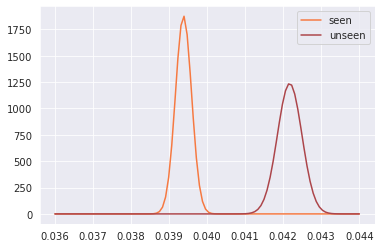

In [410]:
seen_sigmas = []
unseen_sigmas = []

for batch_index in range(len(model.labels_list)):
    for inner_batch_index in range(model.labels_list[batch_index].size(0)):
        class_label = model.labels_list[batch_index][inner_batch_index].item()
#         if class_label <= 151:
        if class_label not in [11,18,19,25,26,28,30,31,32,41,74,75,98,113,138,139,161,177,180,182,183,192,199,177]:
            seen_sigmas.append(model.sigmas_list[batch_index][inner_batch_index].mean().item())
        else:
            unseen_sigmas.append(model.sigmas_list[batch_index][inner_batch_index].mean().item())
            
seen_sigmas = np.array(seen_sigmas)
unseen_sigmas = np.array(unseen_sigmas)
print('seen:')
print(seen_sigmas.mean())
print(seen_sigmas.std())
print('\nunseen:')
print(unseen_sigmas.mean())
print(unseen_sigmas.std())
# for plotting
sns.set_style('darkgrid')
x_min = 0.036#np.concatenate((seen_sigmas, unseen_sigmas)).min()
x_max = 0.044#np.concatenate((seen_sigmas, unseen_sigmas)).max()
x = np.linspace(x_min, x_max, 100)
y_seen = scipy.stats.norm.pdf(x,seen_sigmas.mean(),seen_sigmas.std())
y_unseen = scipy.stats.norm.pdf(x,unseen_sigmas.mean(), unseen_sigmas.std()/100)


plt.plot(x,y_seen, color='#F67941', label = 'seen')
plt.plot(x,y_unseen, color='#AC454A', label = 'unseen')
plt.legend()
plt.savefig(figure_path + 'zero_shot_uncertainty.pdf',bbox_inches='tight')

0.08514898966284508
0.07866149883665921


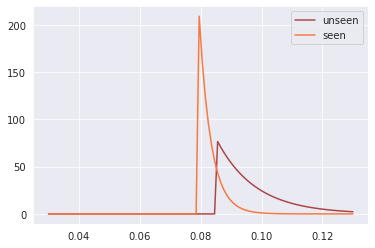

In [464]:
# print(model.sigmas_list[0])

# unseen_attrs = [101-1, 145-1, 151-1, 235 -1,308-1, 312+101-1, 312+145-1, 312+151-1, 312+235 -1,312+308-1]
unseen_attrs = [101, 145, 151, 235 ,308]#, 312+101, 312+145, 312+151, 312+235 ,312+308]
# unseen_attrs = [101+1, 145+1, 151+1, 235 +1,308+1, 312+101+1, 312+145+1, 312+151+1, 312+235 +1,312+308+1]
# unseen_attrs = [101, 101+1, 145, 145+1, 151, 151+1, 235,235 +1,308,308+1]
seen_attrs = [i for i in range(312)if i not in unseen_attrs]
unseen_mask = torch.tensor([1 if x in unseen_attrs else 0 for x in range(312)], device=device).repeat(model.sigmas_list[0].size(0),1)
# print(unseen_mask.size())

seen_mask = 1. - unseen_mask
# print(seen_mask.size())
unseen_sigmas_means = []

seen_sigmas_means = []


for batch_index in range(len(model.sigmas_list)):
# for batch_index in range(2):
    if model.sigmas_list[batch_index].size(0)==64:
        sigmas = model.sigmas_list[batch_index]
        sigmas_new = torch.zeros(64, 312, 1,device=device)
        sigmas_new += sigmas.view(64,-1,2)[:,:,0].unsqueeze(2)
        sigmas_new += sigmas.view(64,-1,2)[:,:,1].unsqueeze(2)
        sigmas = sigmas_new[:,:,0]
#         print(sigmas.size())
        unseen_sigmas = sigmas * unseen_mask
        unseen_sigmas_means += unseen_sigmas.mean(dim=0)[[unseen_attrs]].tolist()
        seen_sigmas = sigmas * seen_mask
        seen_sigmas_means += seen_sigmas.mean(dim=0)[[seen_attrs]].tolist()
#         print(seen_sigmas.mean())


print(np.mean(unseen_sigmas_means))
print(np.mean(seen_sigmas_means))


x_min = 0.03#min(np.array(unseen_sigmas_means).min(), np.array(seen_sigmas_means).min())
x_max = 0.13
#min(np.array(unseen_sigmas_means).max(), np.array(seen_sigmas_means).max())


# x_min = np.concatenate((unseen_sigmas_means, unseen_sigmas)).min()
# x_max = np.concatenate((seen_sigmas, unseen_sigmas)).max()
x = np.linspace(x_min, x_max, 100)
y_unseen = scipy.stats.expon.pdf(x,np.mean(unseen_sigmas_means),np.std(unseen_sigmas_means))
y_seen = scipy.stats.expon.pdf(x,np.mean(seen_sigmas_means),np.std(seen_sigmas_means))
plt.plot(x,y_unseen, color='#AC454A', label = 'unseen')
plt.plot(x,y_seen, color='#F67941', label = 'seen')
plt.legend()

# uncertain_onehot = torch.tensor([[0., 0., 1.]], device=device).repeat(images.size(0), attribute_size, 1)
# print(unseen_batch_mask.size())
# #308
# # 101
# # 235
# # 145
# 151
# plt.savefig(figure_path + 'zero_shot_attr_uncertainty.pdf',bbox_inches='tight')

28858
470


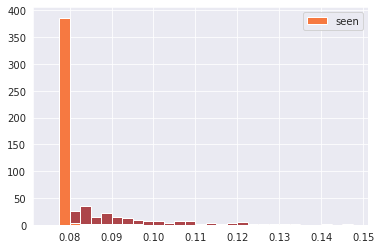

In [481]:
# plt.hist(unseen_sigmas)
# plt.hist(seen_sigmas)
# plt.hist(unseen_sigmas_means)
# plt.hist(seen_sigmas_means)
print(len(seen_sigmas_means))
print(len(unseen_sigmas_means))
plt.hist(np.array(unseen_sigmas_means),
         bins = np.arange(0.075, 0.15, 0.0025),
         color='#AC454A',
         den
         weights=np.ones_like(np.array(unseen_sigmas_means)))

plt.hist(np.array(seen_sigmas_means),
         bins = np.arange(0.075, 0.15, 0.0025),
         color='#F67941',
         density=True,
         label='seen'
        )

plt.legend()

In [36]:
print(trainer.mean_attr_accs)
print()
print(trainer.mean_drop_ratio)
print()
print(trainer.mean_sigmas)

[0.6804115720417189, 0.7182754132410755, 0.6702648232812467, 0.714998273745827, 0.6931055609298789, 0.7174276281958041, 0.6983859079039615, 0.7049175507348516, 0.6953701344521149, 0.7296628880759944, 0.722016493263452, 0.7092867312224015, 0.7558365218017412, 0.7460860590571943, 0.7157794172349183]

[0.057426291227500925, 0.05609082130174483, 0.06299703259782125, 0.05952211805889683, 0.06739816001506262, 0.0625436188633083, 0.061809110545342966, 0.06241330280098864, 0.05440532888776513, 0.054207162390793526, 0.05429709133922413, 0.0504565376347752, 0.05158684070232094, 0.04933646605700575, 0.047554582677861695]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [12]:
!ls -a ../

.  ..  urdtc
